Pairs trading results:
             pair  total_return  sharpe_ratio  max_drawdown
0     (AAPL, MAR)     42.559567      5.423497     -0.493954
1    (AAPL, PANW)      6.613381      0.527918     -1.151065
2    (MSFT, BKNG)     67.068600      5.398032     -2.348845
3    (MSFT, LRCX)     44.407668      5.161191     -0.506788
4     (MSFT, MAR)     71.201556      5.601152     -0.338022
5   (AMZN, CMCSA)     31.907071      4.312827     -4.732643
6   (GOOGL, CSCO)     10.444524     14.007911      0.000000
7   (GOOGL, INTU)     26.524738      2.735954     -1.425878
8    (META, ADBE)     46.778917      4.672232     -0.706778
9    (TSLA, QCOM)    119.555578      4.515680     -4.190136
10    (TSLA, CSX)    148.351910      5.599246     -1.698476
11   (NVDA, BKNG)     13.641246      3.025924     -1.232702
12   (CSCO, INTU)      0.276157      0.049495     -2.666160
13   (AVGO, BKNG)     15.016186      3.003406     -5.705539
14   (TMUS, AMGN)     36.997031      4.781308     -1.176993
15    (TMUS, ADI)

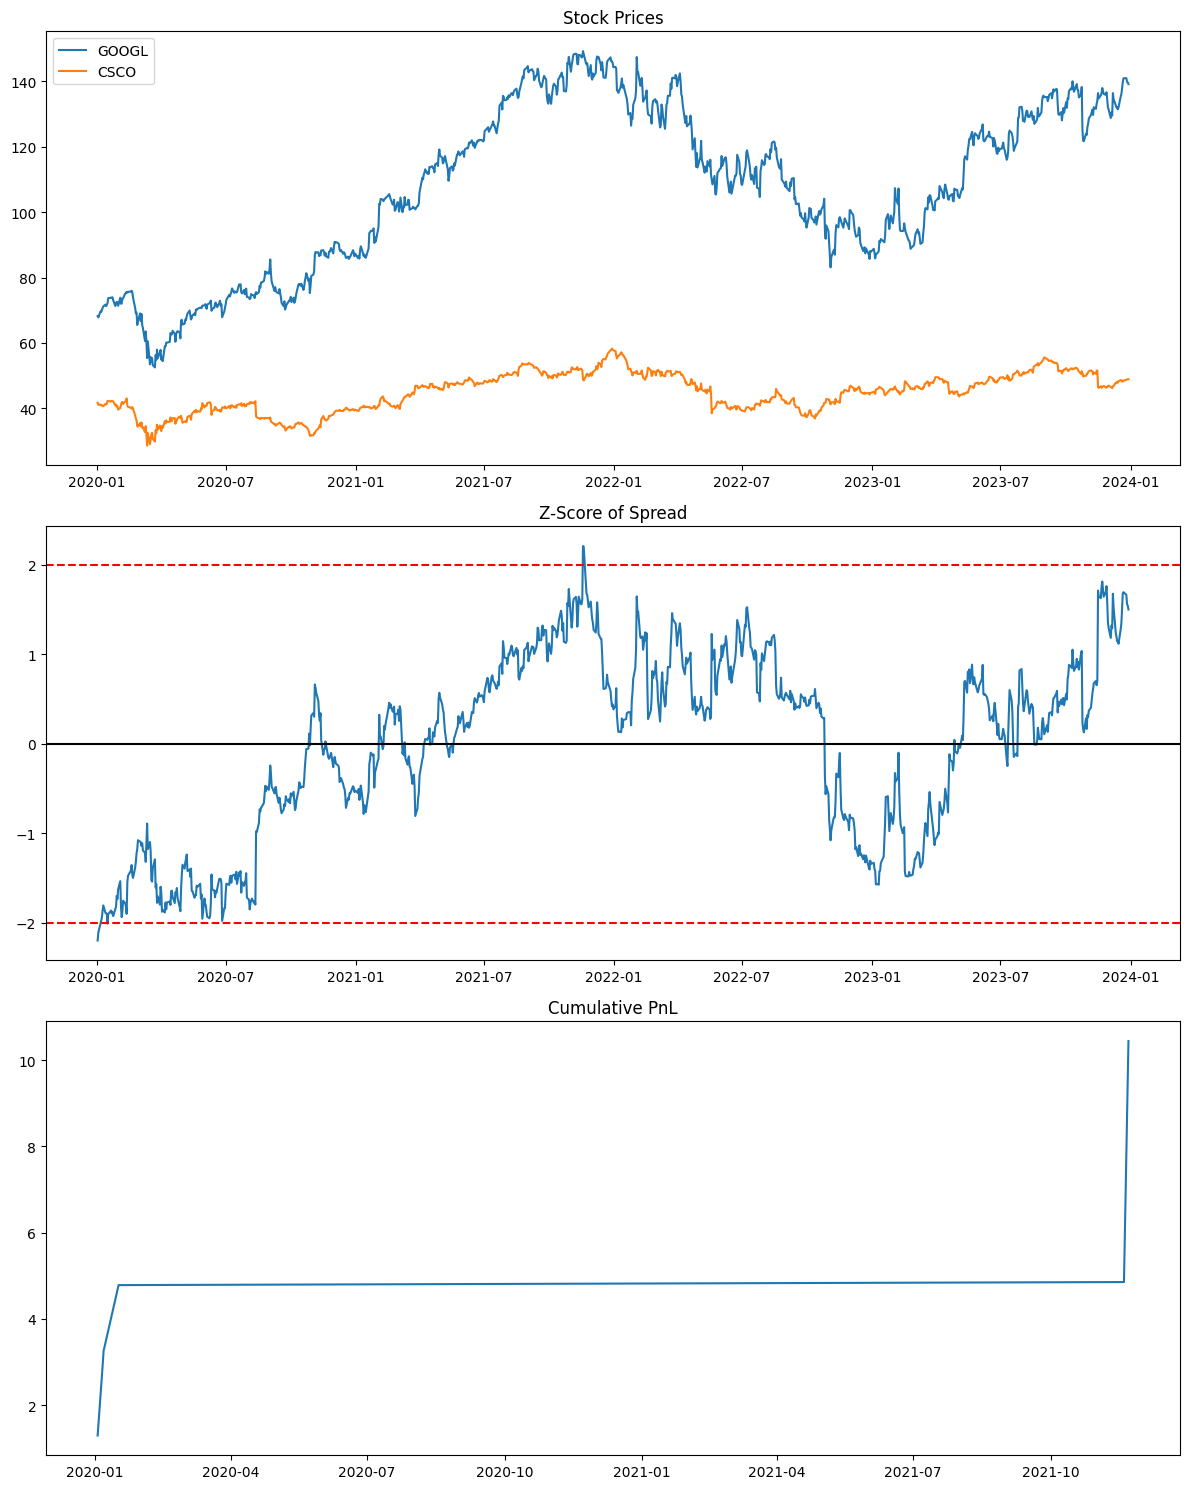

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.regression.linear_model import OLS
import yfinance as yf
from itertools import combinations
import seaborn as sns

class PairsTrader:
    def __init__(self, symbols, start_date, end_date):
        self.symbols = symbols
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        
    def fetch_data(self):
        data = {}
        for symbol in self.symbols:
            stock = yf.Ticker(symbol)
            data[symbol] = stock.history(start=self.start_date, end=self.end_date)['Close']
        self.data = pd.DataFrame(data)
        self.data.dropna(inplace=True)
        
    def test_all_pairs(self):
        results = []
        for symbol1, symbol2 in combinations(self.symbols, 2):
            pair_trader = SinglePairTrader(symbol1, symbol2, self.data[symbol1], self.data[symbol2])
            if pair_trader.test_cointegration():
                pair_trader.calculate_spread()
                pair_trader.backtest()
                pair_trader.calculate_metrics()
                results.append({
                    'pair': (symbol1, symbol2),
                    'total_return': pair_trader.total_return,
                    'sharpe_ratio': pair_trader.sharpe_ratio,
                    'max_drawdown': pair_trader.max_drawdown
                })
        return pd.DataFrame(results)
    
    def plot_best_pair(self, best_pair):
        symbol1, symbol2 = best_pair
        pair_trader = SinglePairTrader(symbol1, symbol2, self.data[symbol1], self.data[symbol2])
        pair_trader.calculate_spread()
        pair_trader.backtest()
        pair_trader.plot_results()

class SinglePairTrader:
    def __init__(self, symbol1, symbol2, data1, data2):
        self.symbol1 = symbol1
        self.symbol2 = symbol2
        self.data = pd.DataFrame({symbol1: data1, symbol2: data2})
        self.beta = None
        self.spread = None
        self.z_score = None
        self.positions = None
        self.pnl = None
        self.total_return = None
        self.sharpe_ratio = None
        self.max_drawdown = None
        
    def test_cointegration(self):
        _, pvalue, _ = coint(self.data[self.symbol1], self.data[self.symbol2])
        return pvalue < 0.05
    
    def calculate_spread(self):
        model = OLS(self.data[self.symbol1], self.data[self.symbol2])
        results = model.fit()
        self.beta = results.params[0]
        self.spread = self.data[self.symbol1] - self.beta * self.data[self.symbol2]
        self.z_score = (self.spread - self.spread.mean()) / self.spread.std()
        
    def generate_signals(self, entry_threshold=2, exit_threshold=0):
        signals = pd.DataFrame(index=self.data.index)
        signals['signal'] = 0
        signals.loc[self.z_score > entry_threshold, 'signal'] = -1
        signals.loc[self.z_score < -entry_threshold, 'signal'] = 1
        signals.loc[abs(self.z_score) < exit_threshold, 'signal'] = 0
        return signals
    
    def backtest(self, entry_threshold=2, exit_threshold=0):
        signals = self.generate_signals(entry_threshold, exit_threshold)
        self.positions = signals.shift(1)
        self.pnl = self.positions['signal'] * self.spread.diff()
        self.pnl = self.pnl[self.pnl != 0]  # Remove days with no trades
        
    def calculate_metrics(self):
        self.total_return = self.pnl.sum()
        self.sharpe_ratio = np.sqrt(252) * self.pnl.mean() / self.pnl.std()
        self.max_drawdown = ((self.pnl.cumsum() - self.pnl.cumsum().cummax())/self.pnl.cumsum().cummax()).min()
        
    def plot_results(self):
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
        ax1.plot(self.data)
        ax1.set_title('Stock Prices')
        ax1.legend([self.symbol1, self.symbol2])
        ax2.plot(self.z_score)
        ax2.axhline(y=2, color='r', linestyle='--')
        ax2.axhline(y=-2, color='r', linestyle='--')
        ax2.axhline(y=0, color='k', linestyle='-')
        ax2.set_title('Z-Score of Spread')
        ax3.plot(self.pnl.cumsum())
        ax3.set_title('Cumulative PnL')
        plt.tight_layout()
        plt.show()


# Example usage with 50 different stocks of same index

symbols = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'NVDA', 'INTC', 'ADBE', 
           'PYPL', 'NFLX', 'CSCO', 'CMCSA', 'PEP', 'AVGO', 'TMUS', 'COST', 'QCOM', 'AMGN', 
           'TXN', 'SBUX', 'CHTR', 'INTU', 'AMD', 'ISRG', 'GILD', 'BKNG', 'MDLZ', 'MU', 'REGN', 
           'ADP', 'ILMN', 'CSX', 'ADI', 'BIIB', 'VRTX', 'MRNA', 'LRCX', 'KDP', 'SNPS', 
           'MCHP', 'MAR', 'MNST', 'CTAS', 'ORLY', 'FTNT', 'PANW']

trader = PairsTrader(symbols, '2020-01-01', '2023-12-31')
trader.fetch_data()
results = trader.test_all_pairs()


print("Pairs trading results:")
print(results)

# Find the best performing pair based on Sharpe ratio
best_pair = tuple(results.loc[results['sharpe_ratio'].idxmax(), 'pair'])
print(f"\nBest performing pair: {best_pair}")

# Plot results for the best pair
trader.plot_best_pair(best_pair)




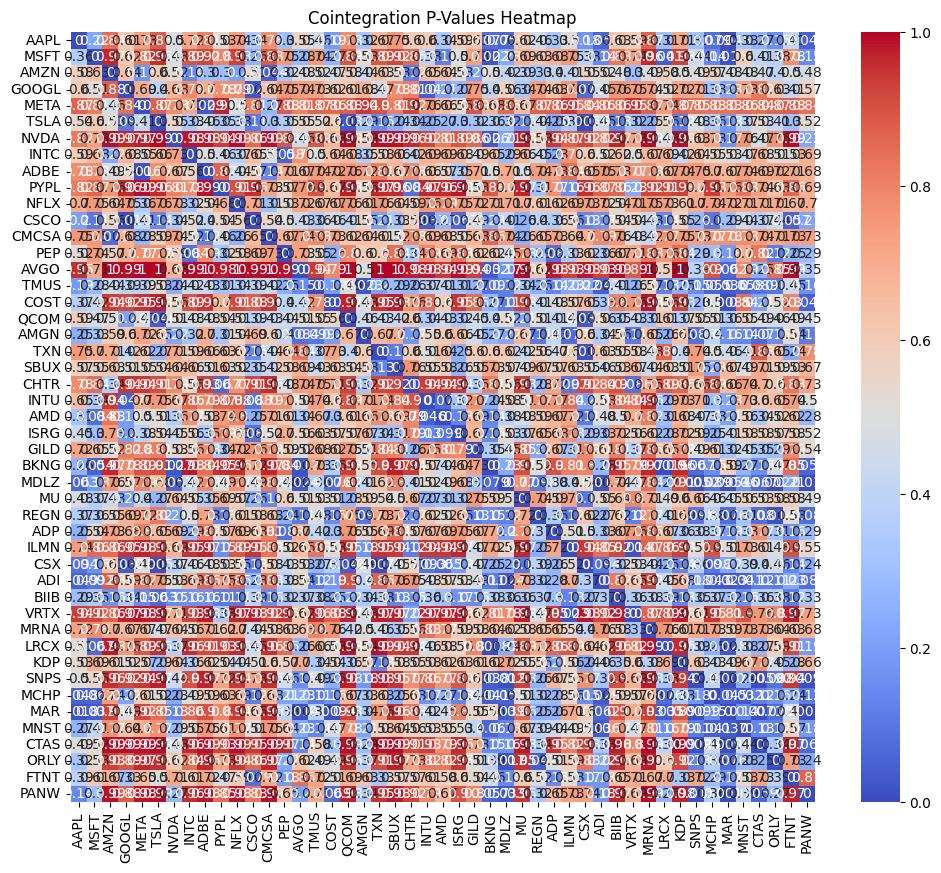

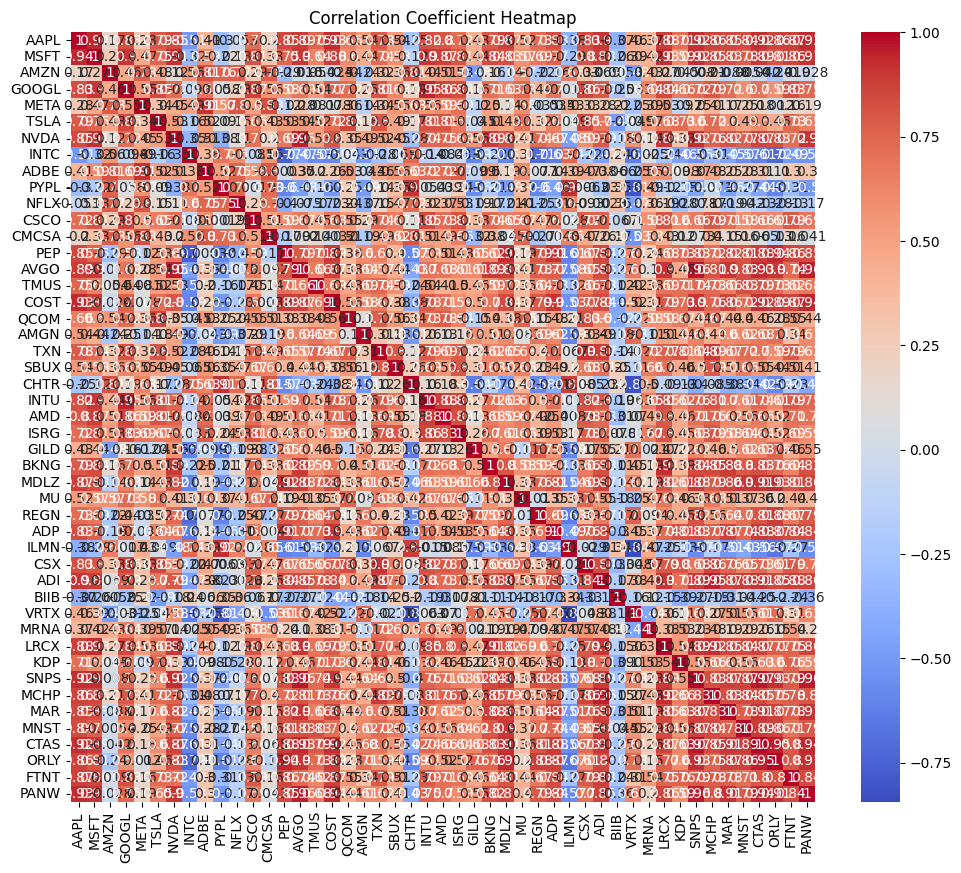

In [6]:
class HeatmapGenerator:
    def __init__(self, symbols, data):
        self.symbols = symbols
        self.data = data

    def generate_cointegration_heatmap(self):
        matrix_size = len(self.symbols)
        pvalues = np.zeros((matrix_size, matrix_size))

        for i, symbol1 in enumerate(self.symbols):
            for j, symbol2 in enumerate(self.symbols):
                if i != j:
                    _, pvalue, _ = coint(self.data[symbol1], self.data[symbol2])
                    pvalues[i, j] = pvalue

        plt.figure(figsize=(12, 10))
        sns.heatmap(pvalues, xticklabels=self.symbols, yticklabels=self.symbols, annot=True, cmap='coolwarm')
        plt.title('Cointegration P-Values Heatmap')
        plt.show()

    def generate_correlation_heatmap(self):
        correlation_matrix = self.data.corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=self.symbols, yticklabels=self.symbols)
        plt.title('Correlation Coefficient Heatmap')
        plt.show()


heatmap_generator = HeatmapGenerator(symbols, trader.data)

heatmap_generator.generate_cointegration_heatmap()
heatmap_generator.generate_correlation_heatmap()